<img align="right" style="max-width: 200px; height: auto" src="./fs_logo.png">

##  Lab 04 - Supervised Deep Learning

Seminar Künstliche Intelligenz, Frankfurt School, 2022

Die Analysen des Seminars **Künstliche Intelligenz** des Zertifikatstudiengangs **Certified Audit Data Scientist (CADS)** basieren auf Jupyter Notebook. Anhand solcher Notebooks ist es möglich eine Vielzahl von Datenanalysen und statistischen Validierungen durchzuführen.

<img align="center" style="max-width: 700px" src="./lab_04_banner.png">

Im letzten Lab haben Sie die verschiedenen Elemente eines Unsupervised Machine Learning Workflow kennengelernt z.B. Datenaufbereitung, Modell Training und Modell Validierung. In diesem vierten Lab werden wir Jupyter Notebook verwenden, um einen ersten **Deep Learning basiertes Workflow** zu implementieren und anzuwenden.

Hierzu werden wir unser erstes **Künstliches Neuronales Netz (ANN)** mit der Python Bibliothek `PyTorch` implementieren, trainieren und evaluieren. Die `PyTorch` Bibliothek ist eine Open-Source Bibliothek für das Deep Learning in Python, die für eine Vielzahl von Anwendungen wie Bildklassifizierung und Verarbeitung natürlicher Sprache verwendet wird. Wir werden das zu implementierende neuronale Netz verwenden, um zu lernen, Bilder des **Zalando Fashion MNIST** Datensatzes zu klassifizieren.

Die nachstehende Abbildung zeigt einen Überblick über den Deep Learning Prozess bzw. die ANN Netzarchitektur, welche wir in diesem Lab implementieren.

<img align="center" style="max-width: 700px" src="https://github.com/HSG-AIML-Teaching/EMBA2022-Lab/blob/main/lab_04/classification.png?raw=1">

Bei etwaigen Fragen wenden Sie sich, wie immer gerne an uns via **marco (dot) schreyer (at) unisg (dot) ch**. Wir wünschen Ihnen Viel Freude mit unseren Notebooks und Ihren revisorischen Analysen!

## Lernziele des Labs:

Nach der heutigen Übung sollten Sie in der Lage sein:

> 1. Die **Grundkonzepte, Funktionsweise und Bestandteile** von Künstlichen Neuronalen Netzen zu verstehen.
> 2. Künstliche Neuronale Netze zur **Klassifikation** unterschiedlichster Datensätze anzuwenden.
> 3. Die Funktionalität der PyTorch Bibliothek für die **Implementierung** und das **Training** von KNN Modellen zu nutzen.
> 4.  Die **Ergebnisse** der Deep Learning basierten Klassifiktion zu interpretieren und einzuschätzen. 

## 1. Einrichten der Analyseumgebung

Ähnlich wie in den vorangegangenen Übungen werden wir zunächst eine Reihe von Python-Bibliotheken importieren, welche die Datenanalyse und -visualisierung ermöglichen. In dieser Übung werden wir die Bibliotheken `PyTorch`, `Pandas`, `Numpy`, `Scikit-Learn`, `Matplotlib` und `Seaborn` verwenden. Nachfolgend importieren wir die benötigten Bibliotheken durch die Ausführung der folgenden Anweisungen:

In [20]:
# import standard python libraries
import os, sys, urllib, io, warnings
import datetime as dt
import numpy as np

Import der `PyTorch` Deep Learning Bibliotheken:

In [3]:
# import the PyTorch deep learning libary
import torch, torchvision
import torch.nn.functional as F
from torch import nn, optim

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Import der `sklearn` Bibliotheken bzw. Evaluationsmetriken:

In [4]:
# import sklearn classification evaluation library
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

Import der `Matplotlib` und `Seaborn` Visualisierungs Bibliotheken und setzen der Visualisierungsparameter:

In [46]:
# import matplotlib, seaborn, and PIL data visualization libary
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

Ausschalten möglicher Warnmeldungen z.B. aufgrund von zukünftigen Änderungen der Bibliotheken:

In [9]:
# set the warning filter flag to ignore warnings
warnings.filterwarnings('ignore')

Aktivieren der sog. Inline-Darstellung von Visualisierungen in Jupyter-Notebook:

In [10]:
%matplotlib inline

Erstellen von Unterverzeichnissen innerhalb des aktuellen Arbeitsverzeichnisses für (1) das Speichern der Originaldaten und (2) trainierten Modelle:

In [11]:
# create the data sub-directory
data_directory = './01_data'
if not os.path.exists(data_directory): os.makedirs(data_directory)

# create the models sub-directory
models_directory = './02_models'
if not os.path.exists(models_directory): os.makedirs(models_directory) 

Festlegen eines zufälligen Seeds zur Gewährleistung der Reproduzierbarkeit:

In [12]:
# init deterministic seed
seed_value = 1234
np.random.seed(seed_value) # set numpy seed
torch.manual_seed(seed_value); # set pytorch seed CPU

Aktivieren des GPU Computing, durch setzen des `device` flag und setzen eines zufälligen `CUDA` Seeds:

In [13]:
# set cpu or gpu enabled device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type

# init deterministic GPU seed
torch.cuda.manual_seed(seed_value)

# log type of device enabled
print('[LOG] notebook with {} computation enabled'.format(str(device)))

[LOG] notebook with cpu computation enabled


Anzeige der Hardware Informationen zu den ggf. verfügbaren GPU(s):

In [14]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


Anzeige der Software Informationen über die verfügbaren `Python` bzw. `PyTorch` Versionen:

In [21]:
# print current Python version
now = dt.datetime.utcnow().strftime("%Y.%m.%d-%H:%M:%S")
print('[LOG {}] The Python version: {}'.format(now, sys.version))

[LOG 2022.10.07-21:38:07] The Python version: 3.10.6 (main, Aug 30 2022, 05:12:36) [Clang 13.1.6 (clang-1316.0.21.2.5)]


In [22]:
# print current PyTorch version
now = dt.datetime.utcnow().strftime("%Y.%m.%d-%H:%M:%S")
print('[LOG {}] The PyTorch version: {}'.format(now, torch.__version__))

[LOG 2022.10.07-21:38:09] The PyTorch version: 1.12.1


## 2. Datenakquise und Datenaufbereitung

Der **Fashion-MNIST Datensatz** ist ein umfangreicher Datensatz mit Bildern zu Modeartikeln, die oftmals als Baseline für den Vergleich verschiedener Computer Vision Modelle verwendet wird. Zudem stellen die Bilder einen 'Hello World' Datensatz für das Trainieren und Testen von Deep Learning Klassifikatoren dar. Die Nachfolgenden Übersicht bietet einen Überblick über einige Beispielbilder des Datensatzes:

<img align="center" style="max-width: 700px; height: 300px" src="https://github.com/HSG-AIML-Teaching/EMBA2022-Lab/blob/main/lab_04/FashionMNIST.png?raw=1">

(Quelle: https://www.kaggle.com/c/insar-fashion-mnist-challenge)

Insgesamt umfasst der **Fashion-MNIST Datensatz** eine Grundgesamtheit von 70.000 Bildern.
Der Datensatz unterteilt sich in **60.000 Trainingsbildern** und **10.000 Validierungsbilder**. Jedes Sample des Datensatzes stellt ein **28x28-Graustufenbild** dar, das gleichzeitg einem von **10 Klassenlabel** zugordnet ist. Insgesamt handelt es sich um einen balanzierten Datensatz, d.h. der Datensatz enthält für jede der 10 Bildklassen genau **6.000** Trainings- und **1.000** Valdierungsbeispiele. Das entsprechende Zalando GitHub Repository enthält zudem weitere Informationen über den Datensatz: [Zalando GitHub Page](https://github.com/zalandoresearch/fashion-mnist).

### 2.1 Download und Assessment der Trainingsdaten

In einem ersten Schritt laden wir die Trainingsbilder des Datensatzes herunter. Dazu legen wir zunächst das Verzeichnis fest, in welchem wir die Trainingsdaten lokal speichern möchten:

In [23]:
train_path = data_directory + '/train_images'

Anschliessend beziehen wir die Trainingsdaten über die `TorchVision`Bibliothek:

In [24]:
# define pytorch transformation into tensor format
transf = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

# download and transform training images
fashion_mnist_train_data = torchvision.datasets.FashionMNIST(root=train_path, train=True, transform=transf, download=True)

100%|████████████████████████████████████████████████████████████████| 26421880/26421880 [00:02<00:00, 9042764.01it/s]


Extracting ./01_data/train_images/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./01_data/train_images/FashionMNIST/raw



100%|███████████████████████████████████████████████████████████████████████| 29515/29515 [00:00<00:00, 315847.59it/s]


Extracting ./01_data/train_images/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./01_data/train_images/FashionMNIST/raw



100%|██████████████████████████████████████████████████████████████████| 4422102/4422102 [00:00<00:00, 4692821.48it/s]


Extracting ./01_data/train_images/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./01_data/train_images/FashionMNIST/raw



100%|████████████████████████████████████████████████████████████████████████| 5148/5148 [00:00<00:00, 7070162.73it/s]

Extracting ./01_data/train_images/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./01_data/train_images/FashionMNIST/raw



Nach erfolgreichem Download verfizieren wir die Anzahl der erhaltenen Trainingssamples:

In [25]:
# determine the number of training data images
len(fashion_mnist_train_data)

60000

Lassen Sie uns nun einige Beispiele der Trainingsbilder betrachten:

In [39]:
# select and set a (random) image id
image_id = 42

# retrieve image exhibiting the image id
fashion_mnist_train_data[image_id]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

Ok, das scheint nicht geklappt zu haben. Trennen wir zunächst Bildinformationen von den Labelinformationen:

In [40]:
fashion_mnist_train_image, fashion_mnist_train_label = fashion_mnist_train_data[image_id]

Wir können uns nun das Label des ausgewählten Bild ausgeben:

In [41]:
fashion_mnist_train_label

9

Nun wissen wir, dass unser ausgewähltes Bild das numerische Label 6 aufweist. Aber was bedeutet also dieses Label 6? 

Innerhalb des Datensatzes ist jedes Bild einem Label von 0 bis 9 zugordnet. Jeder dieser Zahlen steht für eine andere Klasse von Modeartikeln. Eine 'Übersetzung' der numerischen Label ist auf der [Zalando GitHub Page](https://github.com/zalandoresearch/fashion-mnist) zu finden. Nachfolgend definieren wir die sprechenden Übersetzungen der Labels als `Python` Dictionary, da wir sie später im Rahmen der Modelevaluation gerne verwenden möchten:

In [42]:
fashion_classes = {0: 'T-shirt/top',
                    1: 'Trouser',
                    2: 'Pullover',
                    3: 'Dress',
                    4: 'Coat',
                    5: 'Sandal',
                    6: 'Shirt',
                    7: 'Sneaker',
                    8: 'Bag',
                    9: 'Ankle boot'}

Uns ist es nun also möglich das Label in den Namen des Modeartikels umzuwandeln:

In [43]:
fashion_classes[fashion_mnist_train_label]

'Ankle boot'

Wunderbar, in einem nächsten Schritt möchten wir nun auch die zugehörigen Bildinformationen visualisieren:

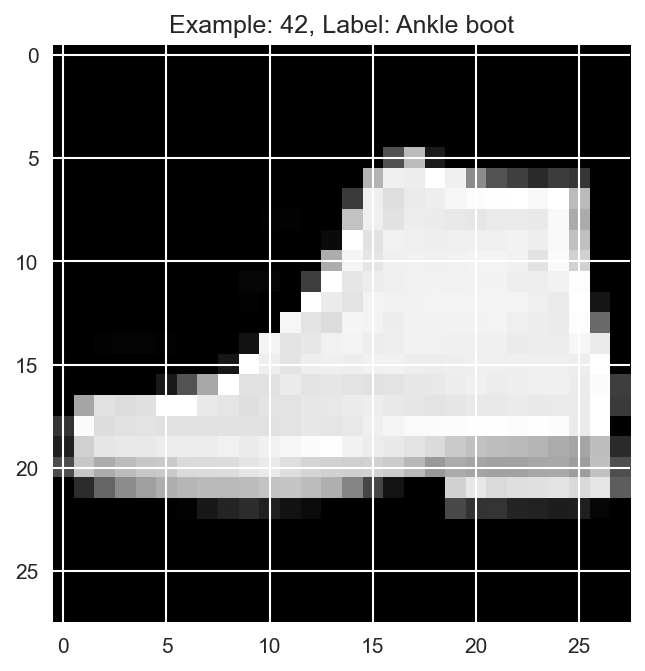

In [47]:
# define tensor to image transformation
trans = torchvision.transforms.ToPILImage()

# set image plot title 
plt.title('Example: {}, Label: {}'.format(str(image_id), fashion_classes[fashion_mnist_train_label]))

# plot mnist handwritten digit sample
plt.imshow(trans(fashion_mnist_train_image), cmap='gray')

### 2.2 Download und Assessment der Evaluationsdaten

Dazu legen wir nun auch das Verzeichnis fest, in welchem wir die Evaluationsdaten lokal speichern möchten:

In [49]:
eval_path = data_directory + '/eval_images'

Anschliessend beziehen wir auch die Evaluationsdaten über die `TorchVision`Bibliothek:

In [50]:
# define pytorch transformation into tensor format
transf = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

# download and transform training images
fashion_mnist_eval_data = torchvision.datasets.FashionMNIST(root=eval_path, train=False, transform=transf, download=True)

100%|████████████████████████████████████████████████████████████████| 26421880/26421880 [00:03<00:00, 6772281.87it/s]


Extracting ./01_data/eval_images/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./01_data/eval_images/FashionMNIST/raw



100%|███████████████████████████████████████████████████████████████████████| 29515/29515 [00:00<00:00, 320123.30it/s]


Extracting ./01_data/eval_images/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./01_data/eval_images/FashionMNIST/raw



100%|██████████████████████████████████████████████████████████████████| 4422102/4422102 [00:01<00:00, 4050571.57it/s]


Extracting ./01_data/eval_images/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./01_data/eval_images/FashionMNIST/raw



100%|████████████████████████████████████████████████████████████████████████| 5148/5148 [00:00<00:00, 7344311.90it/s]

Extracting ./01_data/eval_images/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./01_data/eval_images/FashionMNIST/raw



Abschliessend verfizieren wir auch die erhaltenen Evaluationsdaten:

In [51]:
# determine the number of evaluation data images
len(fashion_mnist_eval_data)

10000

## 3. Artificial Neural Network Implementierung

In diesem Abschnitt möchten wir uns mit der zugrundeliegenden Idee und dem Aufbau eines tiefen **Artificial Neural Network (ANN)** vertraut zu machen. Hierzu werden wir die einzelne Bausteine und die spezifische Netzwerkstruktur von ANNs anhand der `PyTorch` Open-Source-Bibliothek implementieren.

### 3.1 Artificial Neural Network Architektur

Unsere Zielsetzung ist es ein **Artificial Neural Network** zu implementieren um Fashion-MNIST Bilder zu klassifizieren. Das ANN soll hierzu ein Modell zu lernen, dass die Bilder mit Umfang 28x28 Pixel entsprechend den Label der Klassen von Modeartikeln zuordnet. Bevor wir jedoch mit der Implementierung beginnen, wollen wir kurz nochmals den zu entwickelnden Prozess vor Augen führen:

<img align="center" style="max-width: 1000px" src="https://github.com/HSG-AIML-Teaching/EMBA2022-Lab/blob/main/lab_04/process.png?raw=1">

Wir möchten nun ein Artificial Neural Network implementieren, das wir **FashionMNISTNet** nennen. Das ANN soll aus drei Layern von jeweils **fully connected** künstlichen Neuronen bestehen. Zudem soll das **FashionMNISTNet** die folgende Anzahl von Neuronen pro Schicht enthalten: 100 Neuronen in der ersten Schicht, 50 Neuronen in der zweiten Schicht und 10 Neuronen in der dritten Schicht. Bitte beachten Sie, die Dimensionalität der Ausgabe an der dritten Schicht entspricht hierbei der Anzahl der Klassen des Fashion-MNIST Datensatzes.

Die Implementierung von Netzwerkarchitekturen als **separate Klassen** in `PyTorch` ist gute Praxis im Rahmen von Deep-Learning-Projekten. Hierdurch ist es möglich mehrere Instanzen von Modellen mit identischer Netzwerkarchitektur zu erstellen und trainieren. Dies bietet uns zum Beispiel die Möglichkeit, verschiedene Initialisierungen der Netzwerkparameter zu bewerten oder Modelle mit unterschiedlichen Hyperparametern zu trainieren. Wir beginnen nun damit, die Netzwerkarchitektur zu implementieren:

In [56]:
# implement the MNISTNet network architecture
class FashionMNISTNet(nn.Module):
    
    # define the class constructor
    def __init__(self):
        
        # call super class constructor
        super(FashionMNISTNet, self).__init__()
        
        # specify fully-connected (fc) layer 1 - in 28*28, out 100
        self.linear1 = nn.Linear(28*28, 100, bias=True) # the linearity W*x+b
        self.relu1 = nn.ReLU(inplace=True) # the non-linearity 
        
        # specify fc layer 2 - in 100, out 50
        self.linear2 = nn.Linear(100, 50, bias=True) # the linearity W*x+b
        self.relu2 = nn.ReLU(inplace=True) # the non-linarity
        
        # specify fc layer 3 - in 50, out 10
        self.linear3 = nn.Linear(50, 10) # the linearity W*x+b
        
        # add a softmax to the last layer
        self.logsoftmax = nn.LogSoftmax(dim=1) # the softmax
        
    # define network forward pass
    def forward(self, images):
        
        # reshape image pixels
        x = images.view(-1, 28*28)
        
        # define fc layer 1 forward pass
        x = self.relu1(self.linear1(x))
        
        # define fc layer 2 forward pass
        x = self.relu2(self.linear2(x))
        
        # define layer 3 forward pass
        x = self.logsoftmax(self.linear3(x))
        
        # return forward pass result
        return x

Bei der Durchsicht der obigen Implementierung ist Ihnen vielleicht aufgefallen, dass wir innerhalb der dritten Schicht des Netzes eine bisher unbekannte Funktion verwendet haben, die als **Softmax** bezeichnet wird.

### 3.2 Softmax Normalisierung

Die **Softmax-Funktion**, auch bekannt als *normalisierte Exponentialfunktion*, transformiert einen Vektor bestehend aus K rellen Zahlen in einen ebenfalls K-dimensionalen Vektor aus normalisierten Wahrscheinlichkeiten. Hierbei summieren sich die einzelnen Wahrscheinlichkeiten zu 1 auf. 

In unserem Beispiel ist es grds. möglicht, dass innerhalb des dritten Layer die einzelnen Vektorkomponenten einen negativen Wert oder Wert grösser als 1 aufweisen. Das hat zur Folge, dass die einzelnen Vektorkomponenten nicht unmittelbar als Wahrscheinlichkeiten für die verschiedenen Klassen des der Fashion-MNIST Datensatzes interpretiert werden können. Nach Anwendung der Softmax-Funktion ist eine solche Interpretation möglich. 


Im Allgemeinen ist die Softmax-Funktion $\sigma :\mathbb {R} ^{K}\to \mathbb {R} ^{K}$ anhand der nachfolgenden Formel definiert:

<center> $\sigma (\mathbf {z} )_{i}=\ln ({e^{z_{i}} / \sum _{j=1}^{K}e^{z_{j}}})$ </center>

für $i = 1, …, K$ und ${\mathbf {z}}=(z_{1},\ldots ,z_{K})\in \mathbb {R} ^{K}$ (Quelle: [Wikipedia](https://en.wikipedia.org/wiki/Softmax_function)). 

Schauen wir uns nun das nachfolgend Illustrierte Beispiel für die Klassifikation von drei Klassen an. Die Aktivität der Neuronen der dritten Schicht, vor der Softmax-Funktion, resultiert aus dem Forward-Pass des Netzes. Anhand der Softmax-Funktion wird diese Neuronanktivität in eine normalisierte Wahrscheinlichkeit pro Klasse $c_{i}$ umgewandelt:

<img align="center" style="max-width: 800px" src="https://github.com/HSG-AIML-Teaching/EMBA2022-Lab/blob/main/lab_04/softmax.png?raw=1">

Die Softmax-Funktion beschreibt somit, mit welcher Wahrscheinlichkeit das ANN das zu klassifizierende Objekt einer bestimmten Klasse zuordnet. Für das erste Beispiel nihmt das erlernte Modell an, dass es sich mit 64% Wahrscheinlichkeit um ein Objekt der Klasse *Shirt* handelt, mit 4% Wahrscheinlichkeit um ein Objekt der Klasse *Trouser*, und mit 29% Wahrscheinlichkeit um ein Objekt der Klasse *Dress*.

### 3.3 Modell Initialisierung

Nach erfolgreicher Implementierung unseres ersten ANNs, instanziieren wir nun ein Modell des `FashionMNIST` Netzes:

In [57]:
model = FashionMNISTNet()

Anschliessend transferieren wir das Encoder Modell auf die `CPU` oder eine ggf. verfügbare `GPU`:

In [58]:
model = model.to(device)

Sofern verfügbar, prüfen wir ob das Modell erfolgreich auf die `GPU` übertragen wurde:

In [59]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


Once the model is initialized, we can visualize the model structure and review the implemented network architecture by execution of the following cell:

In [85]:
# print the initialized architectures
now = dt.datetime.utcnow().strftime("%Y.%m.%d-%H:%M:%S")
print('[LOG {}] FashionMNIST architecture:\n\n{}\n'.format(now, model))

[LOG 2022.10.08-16:12:53] FashionMNIST architecture:

FashionMNISTNet(
  (linear1): Linear(in_features=784, out_features=100, bias=True)
  (relu1): ReLU(inplace=True)
  (linear2): Linear(in_features=100, out_features=50, bias=True)
  (relu2): ReLU(inplace=True)
  (linear3): Linear(in_features=50, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
)



Abschliessend werfen wir noch einen Blick auf die Anzahl der Modellparameter, die wir im Folgenden beabsichtigen zu trainieren:

In [61]:
# init the number of model parameters
num_params = 0

# iterate over the distinct parameters
for param in model.parameters():

    # collect number of parameters
    num_params += param.numel()
    
# print the number of model paramters
print('[LOG] Number of to be trained FashionMNISTNet model parameters: {}.'.format(num_params))

[LOG] Number of to be trained FashionMNISTNet model parameters: 84060.


Ok, unser ANN Modell umfasst eine beachtliche Gesamtzahl von **84.060 zu trainierenden Modellparametern**.

### 3.4 Fehlerfunktion Initialisierung

Nach Implementierung des **FashionMNISTNet**, sind wir bereit ein entsprechendes Modell zu trainieren. Vor dem Training ist es jedoch zunächst notwendig eine geeignete Fehlerfunktion zu definieren. Grds. möchten wir anhand des Traininsprozesses Modellparameter $\theta$ lernen, welche den Klassifizierungsfehler der wahren bzw. 'ground-truth' Klasse $c^{i}$ und der vorhergesagten Klasse $\hat{c}^{i} = f_\theta(x^{i})$ minimieren. 

Formal ausgedrückt besteht das Trainingsziel darin, Modellparameter $\theta^*$ zu lernen, welche $\arg\min_{\theta} \|C - f_\theta(X)\|$ über alle Trainingsbilder des FashionMNIST-Datensatzes optimieren. Um das Trainingsziel zu erreichen, minimieren wir eine Fehlerfunktion $\mathcal{L_{\theta}}$ als Teil des Netzwerktrainings. Im Rahmen dieses Labs verwenden wir **'Negative Log Likelihood (NLL)'** Fehlerfunktion, die wie nachfolgend definiert ist:<br><br>

<center> $\mathcal{L}^{NLL}_{\theta} (\hat{c}_i) = - \frac{1}{N} \sum_{i=1}^N \log (\hat{c}_i) $, </center>

wobei $\hat{c}^{i}$ die jeweilig durch das Modell vorhergesagten Klassen bezeichnet und $x^{i}$, $i=1,...,n$ die Menge der $n$ Fashion-MNIST Bilder $x^{i}$, $i=1,...,n$ eines Datensatzes bzw. Trainingsbatches. Werfen wir hierzu auch einen Blick auf ein kurzes Beispiel:

<img align="center" style="max-width: 900px" src="https://github.com/HSG-AIML-Teaching/EMBA2022-Lab/blob/main/lab_04/loss.png?raw=1">

Während des Trainings 'bestraft' die **NLL** Fehlerfunktion Modelleparameter, die zu einem hohen Klassifikationsfehler führen. Nachfolgend instanzieren wir die entsprechende **NLL** Fehlerfunktion der `PyTorch` Bibliothek:

In [62]:
# define the optimization criterion / loss function
nll_loss = nn.NLLLoss()

Anschliessend transferieren wir die Berchnung der Fehlerfunktion auf die `CPU` oder eine ggf. verfügbare `GPU`:

In [63]:
nll_loss = nll_loss.to(device)

## 4. Artificial Neural Network Training

In diesem Abschnitt möchten wir nun ein ANN-Modell anhand der Fashion-MNIST Trainingsbilder trainieren. Darüber hinaus werfen wir einen detaillierten Blick auf die einzelnen Trainingshyperparameter und Trainingsschritte sowie den Trainingsfortschritt im Zeitverlauf. 

### 4.1 Definition der Hyperparameter

Beginnen wir nun damit, ein ANN Modell für **20 Trainingsepochen** und **128 Fashion-MNIST Bildern pro Mini-Batch** zu trainieren. Diese Konfiguration der Hyperparameter bedeutet, dass der Datensatz dem ANN insgesamt zwanzig mal in Mini-Batches von 128 jeweils Bildern zugeführt wird. Diese Hyperparameter Konfiguration hat zu Folge, dass pro Trainingsepoche **469 Updates** (60.000 Buchungen modulo 128 Bilder pro Mini-Batch) der ANN Modellparameter erfolgen. 

In [64]:
# specify the training parameters
num_epochs = 20 # number of training epochs
mini_batch_size = 128 # size of the mini-batches

Auf der Grundlage der Fehlerhöhe eines Mini-Batches berechnet die `PyTorch` Bibliothek automatisiert die Gradienten. Anschliessend werden ANN-Parameter $\theta$ auf Grundlage der ermittelten Gradienten optimiert. Hierzu ist es lediglich notwendig ein gewünschtes Optimierungsverfahren in **PyTorch** zu definieren. In der nachfolgenden Notebook Zelle verwenden wir das im Seminar besprochene **Stochastic Gradient Descent** Verfahren für die Optimierung der Modellparameter $\theta$. Darüber hinaus definieren wir eine eine Lernrate $l = 0.001$:

In [65]:
# define learning rate and optimization strategy
learning_rate = 0.001
optimizer = optim.SGD(params=model.parameters(), lr=learning_rate)

Während der Trainingsphase sollen dem ANN Modell kontinuierlich Mini-Batches der gesamten Trainingsbilder Population zugeführt werden. Hierzu verwenden wir die `DataLoader` Funktionalität der `PyTorch` Bibliothek. Dabei handelt es sich im sog. Iteratoren, welche die Bilder kontinuierlich in Form von Mini-Batches zur Verfügung stellen. In der nachfolgenden Zelle instanzieren wir einen `PyTorch` Dataloader der Trainingsbilder:

In [66]:
fashion_mnist_train_dataloader = torch.utils.data.DataLoader(fashion_mnist_train_data, batch_size=mini_batch_size, shuffle=True)

Nachdem wir die verschiedenen Bausteine des ANN-Modells erfolgreich implementiert und instanziiert haben. Nehmen wir uns Zeit, die Definition des **FashionMNISTNet** als auch die **NLL-Fehlerfunktion** nochmals zu überprüfen und etwaige Fragen zu besprechen.

### 4.2 Training des Modells

Nach Definition der Hyperparameter können wir mit dem Training des Modells beginnen. Für jeden zugeführten Mini-Batch werden im Rahmen des Trainingsprozesses die nachfolgenden Schritte ausgeführt: 

>1. Durchführung des Forwardpass durch das FashionMNISTNet.
>2. Berechnen des NLL-Rekonstruktionsfehlers $\mathcal{L^{NLL}_{\theta}}(x^{i};\hat{x}^{i})$.
>3. Durchführung des Backwardpass durch das FashionMNISTNet.
>4. Update der Netzwerk Parameter $f_\theta(\cdot)$.

Um das Lernen während des Trainings zu gewährleisten, beobachten wir den NLL Rekonstruktionsfehler des ANN-Modells mit fortschreitendem Training. Durch diese Beobachtung ist es möglich auf den Lernfortschritt des Modells zu schliessen. Darüber hinaus kann festgestellt werden, ob bzw. wann der NLL-Fehler konvergiert.

Im Rahmen der Modelloptimierung möchten wir den nachfolgenden `PyTorch`Anweisungen eine besondere Beachtung schenken:

>- `loss.backward()` Berechnung die Gradienten auf der Grundlage des NLL-Fehlers.
>- `optimizer.step()` Aktualisierung der Parameter auf Grundlage der Gradienten.

Nach jeder abgeschlossenen Trainingsepoche möchten wir zudem einen sog. **Modell Checkpoint** speichern. Die Checkpoints enthalten eine Bestandsaufnahme bzw. 'Schnappschuss' der Modellparameter. Im Allgemeinen ist es eine gute Praxis, während des Trainings solche Checkpoints in regelmässigen Abständen zu speichen. Sollte das Training einmal unterbrochen werden, kann es beginnend auf dem letzten Checkpoint wieder fortgesetzt werden. Für das Speichern eines Modell Checkpoints verwenden wir die nachfolgende `PyTorch` Anweisung:

>- `torch.save()`: speichert den Checkpoint der aktuellen Modellparameterwerte auf dem lokalen Dateisystem.


In [67]:
# init collection of training epoch losses
train_epoch_losses = []

# set the model in training mode
model.train()

# train the MNISTNet model
for epoch in range(num_epochs):
    
    # init collection of mini-batch losses
    train_mini_batch_losses = []
    
    # iterate over all-mini batches
    for i, (images, labels) in enumerate(fashion_mnist_train_dataloader):
        
        # push mini-batch data to computation device
        images = images.to(device)
        labels = labels.to(device)

        # run forward pass through the network
        output = model(images)
        
        # reset graph gradients
        model.zero_grad()
        
        # determine classification loss
        loss = nll_loss(output, labels)
        
        # run backward pass
        loss.backward()
        
        # update network paramaters
        optimizer.step()
        
        # collect mini-batch reconstruction loss
        train_mini_batch_losses.append(loss.data.item())
    
    # determine mean min-batch loss of epoch
    train_epoch_loss = np.mean(train_mini_batch_losses)
    
    # print epoch loss
    now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
    print('[LOG {}] epoch: {} train-loss: {}'.format(str(now), str(epoch), str(train_epoch_loss)))
    
    # set filename of actual model
    model_name = 'fashion_mnist_model_epoch_{}.pth'.format(str(epoch))

    # save current model to GDrive models directory
    torch.save(model.state_dict(), os.path.join(models_directory, model_name))
    
    # determine mean min-batch loss of epoch
    train_epoch_losses.append(train_epoch_loss)

[LOG 20221008-14:55:41] epoch: 0 train-loss: 2.285720911107338
[LOG 20221008-14:55:46] epoch: 1 train-loss: 2.2358490414202596
[LOG 20221008-14:55:50] epoch: 2 train-loss: 2.1736812820312563
[LOG 20221008-14:55:54] epoch: 3 train-loss: 2.087764346269148
[LOG 20221008-14:55:59] epoch: 4 train-loss: 1.9712947373197023
[LOG 20221008-14:56:04] epoch: 5 train-loss: 1.8303059153973675
[LOG 20221008-14:56:09] epoch: 6 train-loss: 1.68026444932291
[LOG 20221008-14:56:13] epoch: 7 train-loss: 1.5352850400054379
[LOG 20221008-14:56:19] epoch: 8 train-loss: 1.4042655003350426
[LOG 20221008-14:56:24] epoch: 9 train-loss: 1.2910582612572448
[LOG 20221008-14:56:29] epoch: 10 train-loss: 1.1974826250503312
[LOG 20221008-14:56:34] epoch: 11 train-loss: 1.121235416769219
[LOG 20221008-14:56:40] epoch: 12 train-loss: 1.059404863858782
[LOG 20221008-14:56:45] epoch: 13 train-loss: 1.0090221826201562
[LOG 20221008-14:56:52] epoch: 14 train-loss: 0.9675394610555441
[LOG 20221008-14:56:59] epoch: 15 train-l

In einem nächsten Schritt visualisieren wir den jeweiligen NLL-Fehler für jede Trainingsepoche:

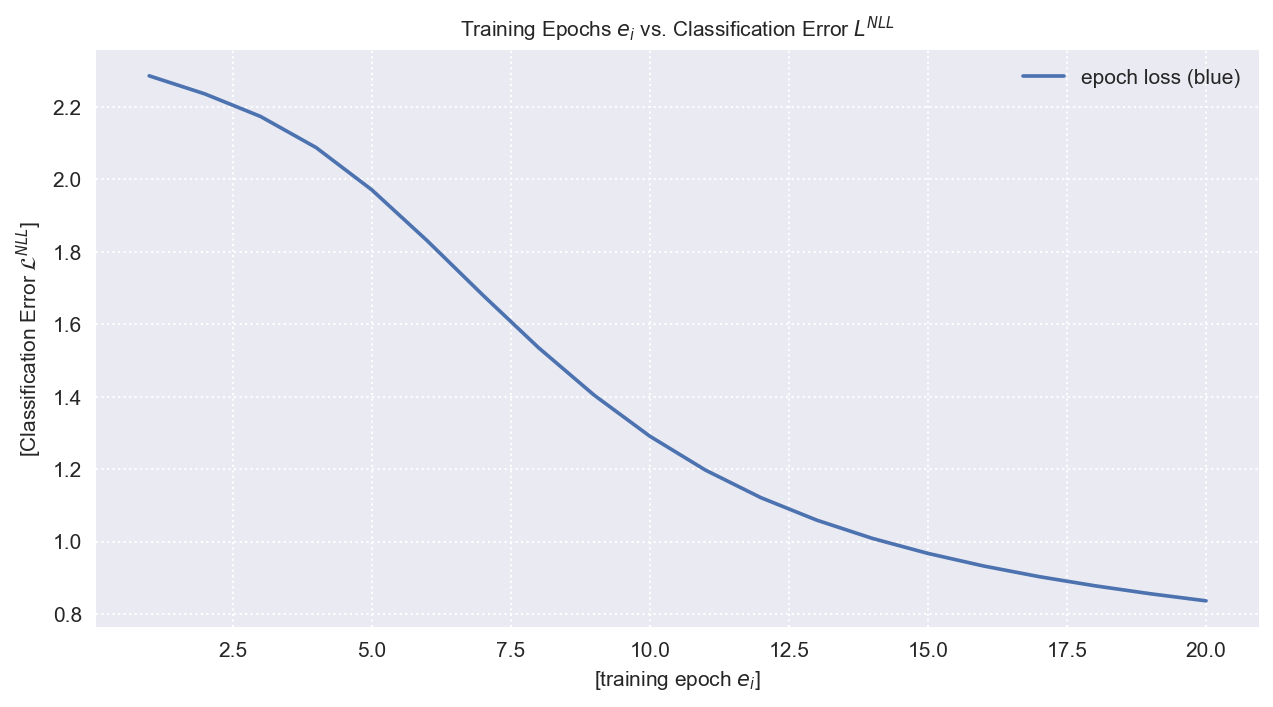

In [68]:
# prepare plot
fig = plt.figure()
ax = fig.add_subplot(111)

# add grid
ax.grid(linestyle='dotted')

# plot the training epochs vs. the epochs' classification error
ax.plot(np.array(range(1, len(train_epoch_losses)+1)), train_epoch_losses, label='epoch loss (blue)')

# add axis legends
ax.set_xlabel("[Training Epoch $e_i$]", fontsize=10)
ax.set_ylabel("[Classification Error $\mathcal{L}^{NLL}$]", fontsize=10)

# set plot legend
plt.legend(loc="upper right", numpoints=1, fancybox=True)

# add plot title
plt.title('Training Epochs $e_i$ vs. Classification Error $L^{NLL}$', fontsize=10);

Es ist zu beobachten, dass der NLL-Fehler des ANN Models nach fünf Epochen kontinuierlich zu sinken beginnt. Diese Beobachtung impliziert, dass es dem Modell sukzessive gelingt die innerhalb des Datensatzes enthaltenen Bilder korrekt zu klassifizieren. Anhand der Visualisierung wird jedoch auch deutlich, dass das Modell noch einige Epochen weiter trainiert werden könnte bis der NLL-Fehler nicht mehr sinkt bzw. konvergiert.

## 5. Artificial Neural Network Modell Evaluation

In diesem Abschnitt möchten wir die Fähigkeit des erlernten ANN Modells zur Klassifikation von Fashion-MNIST Bilder evaluieren. Hierzu werden wir auf vortrainierte ANN Modelle zurück greifen. Die Evaluation umfasst die 10.000 Evaluationsbilde des Fashion-MNIST Datensatzes.

### 5.1 Laden eines Modell Checkpoints

Für die Evaluation laden wir üblicherweise das ANN-Modell mit **geringstem NLL-Fehler** oder verwenden ein anderes, d.h. bereits vortrainiertes, Modell. Im Rahmen des Trainings hatten wir pro Epoche jeweils ein Checkpoint der Modellparameter innerhalb des lokalen Modellverzeichnis gespeichert. Wir werden nun einen bereits für **20 Trainingsepochen** trainierten Modell Checkpoint laden:

In [70]:
# restore pre-trained model snapshot
best_model_name = 'https://raw.githubusercontent.com/HSG-AIML-Teaching/GSERM2022-Lab/master/lab_04/models/fashion_mnist_model_epoch_19.pth'

# read stored model from the remote location
model_bytes = urllib.request.urlopen(best_model_name)

# load model tensor from io.BytesIO object
model_buffer = io.BytesIO(model_bytes.read())

# init pre-trained model class
best_model = FashionMNISTNet()

# load pre-trained models
best_model.load_state_dict(torch.load(model_buffer, map_location=torch.device('cpu')))

<All keys matched successfully>

Nun können wir die Modellstruktur visualisieren und die Netzarchitektur nochmals durch das Ausführen der folgenden Zelle überprüfen:

In [71]:
# print the initialized architectures
now = dt.datetime.utcnow().strftime("%Y.%m.%d-%H:%M:%S")
print('[LOG {}] FashionMNIST architecture:\n\n{}\n'.format(now, best_model))

[LOG 2022.10.08-15:06:55] FashionMNIST architecture:

FashionMNISTNet(
  (linear1): Linear(in_features=784, out_features=100, bias=True)
  (relu1): ReLU(inplace=True)
  (linear2): Linear(in_features=100, out_features=50, bias=True)
  (relu2): ReLU(inplace=True)
  (linear3): Linear(in_features=50, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
)



Darüber hinaus setzen wir das geladene Modell in den Evaluationsmodus. Das versetzen in den Evaluationsmodus stellt sicher, dass etwaige Trainingsfunktion, z.B. Regularisierungen wie *Dropout* oder *Batch Normalization*, ausgeschaltet sind:

In [75]:
# set model in evaluation mode
best_model.eval();

### 5.2 Evaluation des Modells

To evaluate our trained model, we need to feed the FashionMNIST images reserved for evaluation (the images that we didn't use as part of the training process) through the model. Therefore, let's again define a corresponding PyTorch data loader that feeds the image tensors to our neural network: 

In [73]:
fashion_mnist_eval_dataloader = torch.utils.data.DataLoader(fashion_mnist_eval_data, batch_size=10000, shuffle=True)

In einem nächsten Schritt berechnen wir den durchschnittlichen **NLL Fehler** für jeden Mini-Batch der Evaluationsbilder des Fashion-MNIST Datensatzes. Dieser Fehlerwert ermöglicht es uns Rückschlüsse für ein etwaiges **Overfitting** des Modells zu ziehen:

In [74]:
# init collection of mini-batch losses
eval_mini_batch_losses = []

# iterate over all-mini batches
for i, (images, labels) in enumerate(fashion_mnist_eval_dataloader):

    # run forward pass through the network
    output = best_model(images)

    # determine classification loss
    loss = nll_loss(output, labels)

    # collect mini-batch reconstruction loss
    eval_mini_batch_losses.append(loss.data.item())

# determine mean min-batch loss of epoch
eval_loss = np.mean(eval_mini_batch_losses)

# print epoch loss
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] eval-loss: {}'.format(str(now), str(eval_loss)))

[LOG 20221008-15:24:22] eval-loss: 0.8421005606651306


Okay, der durchschnittliche **NLL-Fehler** scheint einem ähnlichen Werterbereich wie der letzte Trainingsfehler des Modells zu liegen. Hierdurch ist ein etwaiges **Overfitting** auf den Trainingsdaten unwahrscheinlich. 

Um einen Eindruck von der Qualität des Modells zu erhalten, schauen wir uns nun ein paar beispielhafte Klassifikationen an. Hierzu wählen wir ein zufälliges Bild der Evaluationsdaten aus um den den entsprechenden `PyTorch` Tensor sowie das korrespondierende Label zu erhalten:

In [76]:
# set (random) image id
image_id = 2000

# retrieve image exhibiting the image id
fashion_mnist_eval_image, fashion_mnist_eval_label = fashion_mnist_eval_data[image_id]

In einem ersten Schritt extrahieren wir das **ground-truth** Label des Bildes:

In [77]:
fashion_classes[fashion_mnist_eval_label]

'Bag'

Ok, das ausgewählte Bild soll eine Tasche enthalten. Lassen Sie uns das Bild nun visualiseren und anschauen:

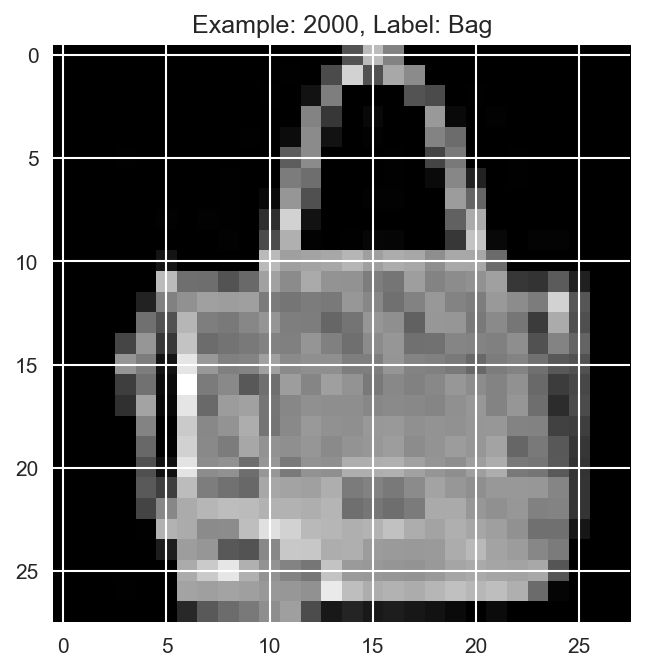

In [78]:
# define tensor to image transformation
trans = torchvision.transforms.ToPILImage()

# set image plot title 
plt.title('Example: {}, Label: {}'.format(str(image_id), fashion_classes[fashion_mnist_eval_label]))

# plot mnist handwritten digit sample
plt.imshow(trans(fashion_mnist_eval_image), cmap='gray')

In einem zweiten Schritt möchten wir nun die **Klassifikation** des Bildes durch das Modell erhalten:

In [79]:
# determine model prediction
prediction = best_model(fashion_mnist_eval_image)

# print the model prediction
print(prediction)

tensor([[-5.5324, -7.3229, -3.6419, -3.8493, -2.9376, -3.1941, -3.4040, -4.9128,
         -0.2235, -4.2964]], grad_fn=<LogSoftmaxBackward0>)


Anschliessend bestimmen wir die vorhergesagte Klasse des Klassifikationsergebnisses:

In [81]:
# determine most probable class
most_probable = torch.argmax(prediction, dim=1).item()

# print the classification result
print('Most probable class label: {}'.format(most_probable))
print('The label corresponds to the following fashion article: {}'.format(fashion_classes[most_probable]))

Most probable class label: 8
The label corresponds to the following fashion article: Bag


Um eine Aussage über die Qualität des gelernten Modells zu treffen, klassifizieren wir nun alle 10.000 Bilder des Trainingsdatensatzes:

In [82]:
predictions = torch.argmax(best_model(fashion_mnist_eval_data.data.float()), dim=1)

Auf Grundlage der Klassifikationen bestimmen wir nun die **Acurracy** des Modells über alle Klassen:

In [83]:
metrics.accuracy_score(fashion_mnist_eval_data.targets, predictions.detach())

0.6712

Lassen Sie uns auch einen Blick auf die zugehörige **Confusion-Matrix** werfen um die Quellen der Fehlklassifikationen zu ermitteln:

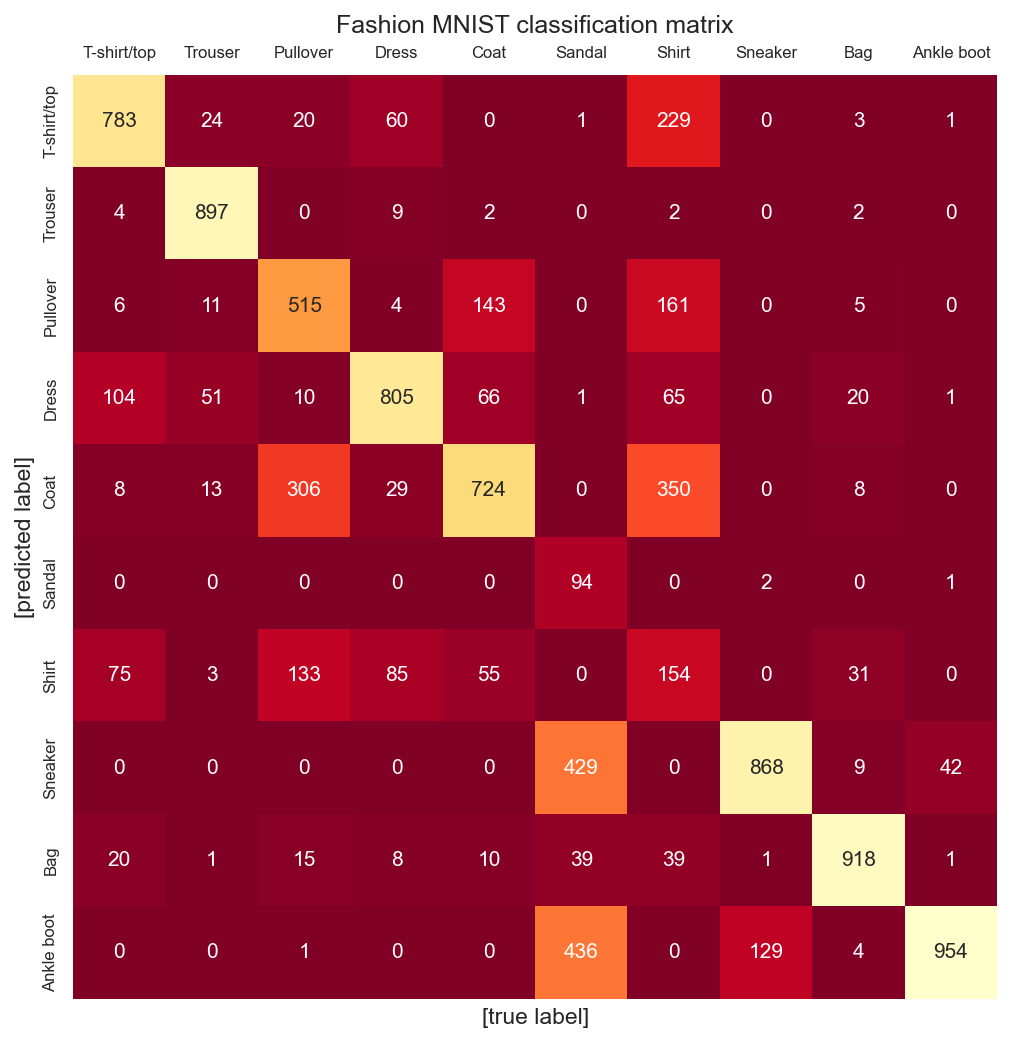

In [84]:
# determine classification matrix of the predicted and target classes
mat = confusion_matrix(fashion_mnist_eval_data.targets, predictions.detach())

# initialize the plot and define size
plt.figure(figsize=(8, 8))

# plot corresponding confusion matrix
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='YlOrRd_r', xticklabels=fashion_classes.values(), yticklabels=fashion_classes.values())
plt.tick_params(axis='both', which='major', labelsize=8, labelbottom = False, bottom=False, top = False, left = False, labeltop=True)

# set plot title
plt.title('Fashion MNIST classification matrix')

# set axis labels
plt.xlabel('[true label]')
plt.ylabel('[predicted label]');

Auf Grundlage der **Confusion-Matrix** wird deutlich, dass unser derzeitiges Modell beispielsweise die Klasse **Sneaker** mit der Klasse **Sandal** verwechselt. Eine ebenfalls hohe Fehlerquelle lässt sich für die Klassen **Shirt** und **Coat** beobachten. Diese Fehler sind nicht sehr überraschend, da die Form der Artikel innerhal der Trainingsbilder eine grosse Ähnlichkeit aufweisen.

## Lab Aufgaben:

Um Ihr wissen zu vertiefen empfehlen wir, die nachfolgenden Übungen zu bearbeiten:

**1. Trainieren Sie das ANN Modell für weniger bzw. mehr Epochen und evaluieren Sie die Vorhersagegenauigkeit.**

> Reduzieren bzw. erhöhen Sie die Anzahl der Trainingsepochen auf **5 Epochen bzw. 100 Epochen** und führen Sie das Modelltraining jeweils erneut durch. Laden und bewerten Sie jeweils  Modell, das den geringsten NLL-Fehler aufweist. Welches Verhalten ist in Bezug auf die Vorhersagegenauigkeit durch die Veränderung der Anzahl der Trainingsepochen zu beobachten?

In [ ]:
# ***************************************************
# Sie können Ihre Lösung an dieser Stelle einfügen
# ***************************************************

**2. Analyse von `shallow` bzw. `deep` Neuronalen Netz Modellen.**

> Evaluieren Sie weitere `shallow` bzw. `deep` Architekturen Neuronaler Netze. Variieren Sie hierzu wahlweise (1) die **Anzahl Schichten** oder (2) die **Anzahl Neuronen** der Architektur. Trainieren Sie für jede Änderung jeweils ein Modell für mindestens 40 Epochen. Analysieren Sie die unterschiedlichen Modelle im Hinblick auf ihre jeweilige Anzahl Parameter und die Accuracy auf den Evaluationsdaten.

In [ ]:
# ***************************************************
# Sie können Ihre Lösung an dieser Stelle einfügen
# ***************************************************

## Lab Zusammenfassung:

Dieses Notebook umfasste eine schrittweise Einführung in den **Entwurf, die Implementierung, das Training und die Auswertung** von neuronalen Netzen zur Klassifizierung von Bildern. Die vorgestellten Code Beispiele und die Übungen können als Ausgangspunkt für die Entwicklung komplexerer, tieferer und maßgeschneiderter **Neuronaler Netze** dienen.